In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

In [2]:
DATASET_URL = "data/"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

In [3]:
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

In [5]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

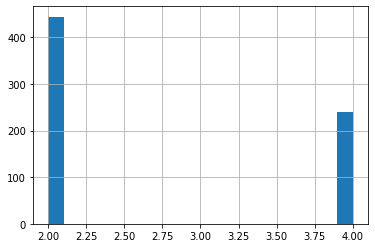

In [6]:
# 2.0 = benign
# 4.0 = malignant
df['class'].hist(bins=20) 

In [7]:
# benign(2.0) = 0
# malignant(4.0) = 1
df['class'] = np.where(df['class'] == 2, 0, 1)

In [8]:
train, test = train_test_split(df, test_size=0.2)

In [9]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
clump_thickness,546.0,4.443223,2.796046,1.0,2.0,4.0,6.0,10.0
un_cell_size,546.0,3.130037,3.061380,1.0,1.0,1.0,5.0,10.0
un_cell_shape,546.0,3.184982,2.993055,1.0,1.0,1.0,5.0,10.0
marginal_adheshion,546.0,2.717949,2.750334,1.0,1.0,1.0,3.0,10.0
single_eph_cell_size,546.0,3.175824,2.167788,1.0,2.0,2.0,4.0,10.0
bare_nuclei,546.0,3.525641,3.640784,1.0,1.0,1.0,6.0,10.0
bland_chromatin,546.0,3.395604,2.433915,1.0,2.0,3.0,4.0,10.0
normal_nucleoli,546.0,2.847985,3.065159,1.0,1.0,1.0,3.0,10.0
mitoses,546.0,1.606227,1.732760,1.0,1.0,1.0,1.0,10.0


In [10]:
train_Y = train.pop("class")
test_Y = test.pop("class")

In [11]:
# normalize - X = (X - mean(X)) / StandardDeviation(X)
def norm(x):
    return (x-train_stats['mean'])/train_stats['std']

In [12]:
norm_train_X = norm(train)
norm_test_X = norm(test)

norm_train_X

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
378,-0.516166,-0.695777,-0.730017,0.466144,-0.081108,-0.693708,-0.573399,-0.276653,-0.349862
71,0.556778,2.244074,-0.395910,1.920513,3.147991,-0.419042,1.480904,1.680831,4.844164
35,-0.873814,-0.695777,-0.730017,-0.624633,-0.542407,-0.693708,-0.573399,-0.602900,-0.349862
482,1.629722,2.244074,2.276944,2.647697,3.147991,0.404957,2.713486,2.333326,4.844164
114,-0.516166,-0.042476,-0.395910,-0.624633,-0.542407,-0.144376,-0.162538,-0.602900,-0.349862
...,...,...,...,...,...,...,...,...,...
149,1.272074,1.590774,1.274623,0.466144,3.147991,1.778287,1.480904,1.680831,3.112822
37,0.556778,-0.369126,-0.730017,-0.624633,-1.003707,-0.693708,1.480904,-0.602900,-0.349862
466,1.987370,0.937474,0.940517,-0.261041,0.380192,1.778287,2.302626,1.354584,-0.349862
447,0.199130,-0.695777,-0.730017,-0.624633,-0.542407,-0.693708,-0.984260,-0.602900,-0.349862


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

In [14]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [15]:
a = enumerate(train_dataset)

print(len(list(a)))

18


In [16]:
# Model
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(16, activation='relu')(inputs)
    x = tf.keras.layers.Dense(8, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

In [17]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

In [18]:
# Evaluate Untrained Model
outputs = model(norm_test_X.values)
outputs_ntrained = np.expand_dims(outputs, axis=2)
loss_value = loss_object(y_true=test_Y.values, y_pred=outputs_ntrained)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.7119


In [19]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

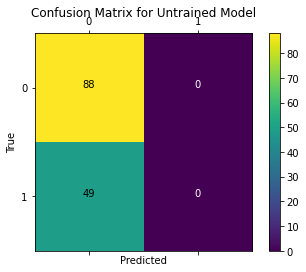

In [20]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

In [21]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''
        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric
        
        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''
        # confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''
        # precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
        # recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)
        # F1 Score
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''
        self.tp.assign(0)
        self.tn.assign(0) 
        self.fp.assign(0)
        self.fn.assign(0)

In [22]:
test_F1Score = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()

<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

In [23]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [24]:
# Apply Gradients
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights
    
    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y, logits)
  
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return logits, loss_value

In [ ]:
# Test
test_model = tf.keras.models.load_model('./test_model')
test_logits, test_loss = apply_gradient(optimizer, loss_object, test_model, norm_test_X.values, test_Y.values)

print(test_logits.numpy()[:8])
print(test_loss.numpy())

del test_model
del test_logits
del test_loss

In [27]:
# Training Loop
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, 
                             train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.
    
    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(tf.reduce_mean(loss_value))

        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)

        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    return losses

In [ ]:
# Test
test_model = tf.keras.models.load_model('./test_model')

test_losses = train_data_for_one_epoch(train_dataset, optimizer, loss_object, test_model, 
                                       train_acc_metric, train_f1score_metric, verbose=False)

for test_loss in test_losses:
    print(test_loss.numpy())

del test_model
del test_losses

In [29]:
def perform_validation():
    losses = []
    for x_val, y_val in test_dataset:
        val_logits = model(x_val) 
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)
    return losses

In [30]:
epochs = 10
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    #Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric)

    #results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    #validation on all batches of test data
    losses_val = perform_validation()

    # results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    #training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()

Start of epoch 0
Training loss for step 0: 0.7474
Training loss for step 1: 0.7968
Training loss for step 2: 0.6437
Training loss for step 3: 0.8853
Training loss for step 4: 0.6410
Training loss for step 5: 0.9758
Training loss for step 6: 0.8310
Training loss for step 7: 0.8280
Training loss for step 8: 0.8569
Training loss for step 9: 0.8611
Training loss for step 10: 0.6253
Training loss for step 11: 0.5914
Training loss for step 12: 0.6218
Training loss for step 13: 0.6775
Training loss for step 14: 0.7752
Training loss for step 15: 0.6350
Training loss for step 16: 0.6646
Training loss for step 17: 0.3360

 Epoch 0: Train loss: 0.7219  Validation Loss: 0.6524, Train Accuracy: 0.6701, Validation Accuracy 0.6458, Train F1 Score: 0.0000, Validation F1 Score: 0.0000
Start of epoch 1
Training loss for step 0: 0.5326
Training loss for step 1: 0.7152
Training loss for step 2: 0.6210
Training loss for step 3: 0.6706
Training loss for step 4: 0.5894
Training loss for step 5: 0.6794
Traini

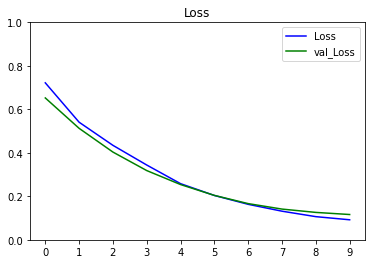

In [31]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend()

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

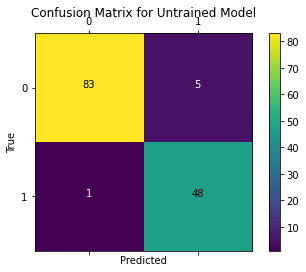

In [32]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')